In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false'
os.environ["CUDA_VISIBLE_DEVICES"]

'2'

In [2]:
import jax
import jax.numpy as np
from jax import jit, grad, random
from jax.experimental import stax, optimizers
import flax.linen as nn

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
# from tqdm import tqdm
import imageio

rand_key = random.PRNGKey(0)

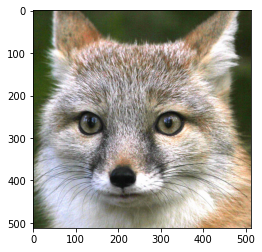

In [3]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(-1, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test, img]
# train_data = [x_test[::2,::2], img[::2,::2]]

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

In [10]:
# Fourier feature mapping
def input_encoder(x, B): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

def input_mapping(x, B, gauss_split=False, cat_input=False):
    if gauss_split:
        x_proj = 2.*np.pi* x[...,None] * B.T[None,:]
        enc = np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)
        return enc.reshape(*enc.shape[:-2],-1)
    if B is not None:
        x_sh = x.shape
        x_proj = (2.*np.pi*x) @ B.T
        enc = np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)
        if cat_input:
            enc = np.concatenate([enc, x], axis=-1)
        return enc.reshape(*x_sh[:-1], -1, x_sh[-1]).swapaxes(-2,-1).reshape(*x_sh[:-1], -1)
    else:
        return x


# JAX network definition
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(3))
    layers.append(stax.Sigmoid)
    return stax.serial(*layers)

# define model using FLAX
class MLP(nn.Module):
    d_layers: int
    features: int
    sigmoid: bool

    @nn.compact
    def __call__(self, x):
        for i in range(self.d_layers-1):
            x = nn.relu(nn.Dense(self.features)(x))
        x = nn.Dense(3)(x)
        if self.sigmoid:
            x = nn.sigmoid(x)
        return x

class MLP_split(nn.Module):
    d_layers: int
    features: int
    d_fusion: int
    d_branch: int
    fuse_mode: str
    fuse_before_act: bool
    sigmoid: bool
    atten: bool

    @nn.compact
    def __call__(self, x):
        xs = np.split(x, 2, -1)
        hs = []
        for xi in xs:
            for i in range(self.d_branch):
                xi = nn.relu(nn.Dense(self.features)(xi))
            hs.append(xi)
        hs = np.stack(hs, -2)
        for i in range(self.d_layers-self.d_branch-self.d_fusion-1):
            hs = nn.relu(nn.Dense(self.features)(hs))
        # fusion step
        if not self.fuse_before_act:
            if self.fuse_mode == 'prod':
                h = nn.relu(nn.Dense(self.features)(hs)).prod(-2)
            elif self.fuse_mode == 'sum':
                h = nn.relu(nn.Dense(self.features)(hs)).sum(-2)
        else:
            if self.fuse_mode == 'prod':
                h = nn.relu(nn.Dense(self.features)(hs).prod(-2))
            elif self.fuse_mode == 'sum':
                h = nn.relu(nn.Dense(self.features)(hs).sum(-2))
                
        if self.atten:
            h = h * nn.Dense(self.features)(x)
        for i in range(self.d_fusion-1):
            h = nn.relu(nn.Dense(self.features)(h))
        h = nn.Dense(3)(h)
        if self.sigmoid:
            h = nn.sigmoid(h)
        return h


In [5]:
# Train model with given hyperparameters and data
def train_model(network_size, learning_rate, iters, B, train_data, test_data, 
                gauss_split=False, cat_input=False):

    if len(network_size) > 3:
        model = MLP_split(*network_size)
    else:
        gauss_split = False
        model = MLP(*network_size)
    init_fn, apply_fn = model.init, model.apply
    # init_fn, apply_fn = make_network(*network_size)
    
    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B, gauss_split, cat_input)))
    model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))
                    
    model_psnr = jit(lambda params, x, y: -10 * np.log10(np.mean((model_pred(params, x).clip(0.,1.) - y) ** 2)))
        
#     model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))

    opt_init, opt_update, get_params = optimizers.adam(learning_rate)
    opt_update = jit(opt_update)

    # _, params = init_fn(rand_key, (-1, input_mapping(train_data[0], B).shape[-1]))
    params = init_fn(rand_key, input_mapping(train_data[0], B, gauss_split, cat_input))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)

        if i % 25 == 0:
            train_psnrs.append(model_psnr(get_params(opt_state), *train_data))
            test_psnrs.append(model_psnr(get_params(opt_state), *test_data))
            pred_imgs.append(model_pred(get_params(opt_state), test_data[0]))
            xs.append(i)
    
    return {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs' : np.stack(pred_imgs),
        'xs': xs,
    }

In [11]:
bvals = 2** np.arange(7) / 2
B = np.reshape(np.eye(2)*bvals[:,None,None], [len(bvals)*2, 2])
enc = input_mapping(np.array([[0.233,0.666]]), B, cat_input=True)
# enc.shape, enc
p = np.ones([1,2]) * 2 * np.pi @ B.T
p, B, bvals, p.shape, enc

(DeviceArray([[  3.1415927,   3.1415927,   6.2831855,   6.2831855,
                12.566371 ,  12.566371 ,  25.132742 ,  25.132742 ,
                50.265484 ,  50.265484 , 100.53097  , 100.53097  ,
               201.06194  , 201.06194  ]], dtype=float32),
 DeviceArray([[ 0.5,  0. ],
              [ 0. ,  0.5],
              [ 1. ,  0. ],
              [ 0. ,  1. ],
              [ 2. ,  0. ],
              [ 0. ,  2. ],
              [ 4. ,  0. ],
              [ 0. ,  4. ],
              [ 8. ,  0. ],
              [ 0. ,  8. ],
              [16. ,  0. ],
              [ 0. , 16. ],
              [32. ,  0. ],
              [ 0. , 32. ]], dtype=float32),
 DeviceArray([ 0.5,  1. ,  2. ,  4. ,  8. , 16. , 32. ], dtype=float32),
 (1, 14),
 DeviceArray([[ 0.66835207,  0.9943008 ,  0.21200702, -0.4143754 ,
               -0.7542511 , -0.9904615 ,  0.27295047,  0.7438451 ,
                0.1066111 , -0.97726816,  0.91010606,  0.65658605,
               -0.13778953, -0.9620281 ,  0.233

## Train networks with different input mappings

We compare the following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

<!-- - Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2 \pi \sigma^{j/m} \mathbf{v}),\sin(2 \pi \sigma^{j/m} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, m-1$.  -->

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$

In [20]:
learning_rate = 1e-4
iters = 10000

mapping_size = 256

B_dict = {}
# Standard network - no mapping
# B_dict['none'] = None
# Basic mapping
# B_dict['basic'] = np.eye(2)
# # Three different scales of Gaussian Fourier feature mappings

# B_gauss = random.normal(rand_key, (mapping_size, 2))
# for scale in [1., 10., 100.,]:
#     B_dict[f'gauss_{scale}'] = B_gauss * scale

# bvals = 2.**np.linspace(0,6,mapping_size//2) - 1
# B_dict['posenc'] = np.reshape(np.eye(2)*bvals[:,None,None], [len(bvals)*2, 2])

bvals = 2**np.arange(7) / 2
B_dict['posenc_2'] = np.reshape(np.eye(2)*bvals[:,None,None], [len(bvals)*2, 2])

# net_cfgs = [
# #     (4,256)
#     (5, 256, True),
# #     (5, 256, 1,1, 'prod', False),
# # #     (5, 256, 1,1, 'sum', False),
# #     (5, 256, 1,1, 'prod', True),
# # #     (5, 256, 1,1, 'sum', True),
#     (5, 256, 2,1, 'prod', False),
# #     (5, 256, 2,1, 'sum', False),
# #     (5, 256, 2,1, 'prod', True),
# #     (5, 256, 2,1, 'sum', True),
# ]

net_cfgs = [
#     (3, 256, True),
#     (5, 256, 2, 1, 'prod', False, True),
#     (5, 256, False),
#     (5, 256, 2, 1, 'prod', False, False, True),
    (5, 256, 2, 1, 'prod', False, True, True),
#     (5, 256, 1, 1, 'prod', False, False, True),
]

# cat_input = False
# This should take about 2-3 minutes
outputs = {}
for i, cfg in tqdm(enumerate(net_cfgs)):
    for k in tqdm(B_dict):
        for cat_input in [True]: #[True, False]:
            gauss_split = True if 'gauss' in k else False
            outputs[f"S_{len(cfg)>3}_A_{cfg[-2]}_C_{cat_input}_" + k] = \
                train_model(cfg, learning_rate, iters, B_dict[k], 
                                   train_data, test_data, gauss_split, cat_input)

In [ ]:
B_dict = {}
B_dict['split_none'] = None
B_dict['split_basic'] = np.eye(2)
for scale in [1., 10., 100.]:
    B_dict[f'split_gauss_{scale}'] = B_gauss * scale

outx = {}
for k in tqdm(B_dict):
    gauss_split = True if 'gauss' in k else False
    ncfg = (4, 256, 1,1, 'prod', True)
    outx[k] = train_model(ncfg, learning_rate, iters, B_dict[k], 
                           train_data, test_data, gauss_split)


## Plot results

In [15]:
# Show final network outputs
def vis_res():
    plt.figure(figsize=(24,12))
    W = 5
    N = len(outputs) + 1
    H = (N - 1) // W + 1
    for i, k in enumerate(outputs):
        plt.subplot(H,W,i+1)
        plt.imshow(outputs[k]['pred_imgs'][-1])
        plt.title(k)
    plt.subplot(H,W,N)
    plt.imshow(img)
    plt.title('GT')
    plt.show()
    # Plot train/test error curves

    plt.figure(figsize=(16,6))

    plt.subplot(121)
    for i, k in enumerate(outputs):
        plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
    plt.title('Train error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()

    plt.subplot(122)
    for i, k in enumerate(outputs):
        plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
    plt.title('Test error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()

    plt.show()
  

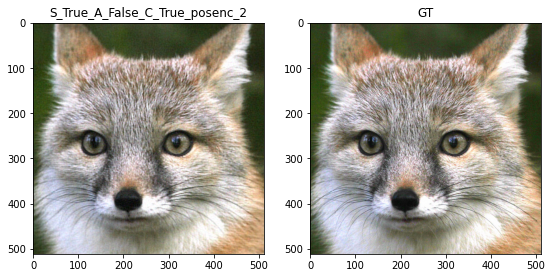

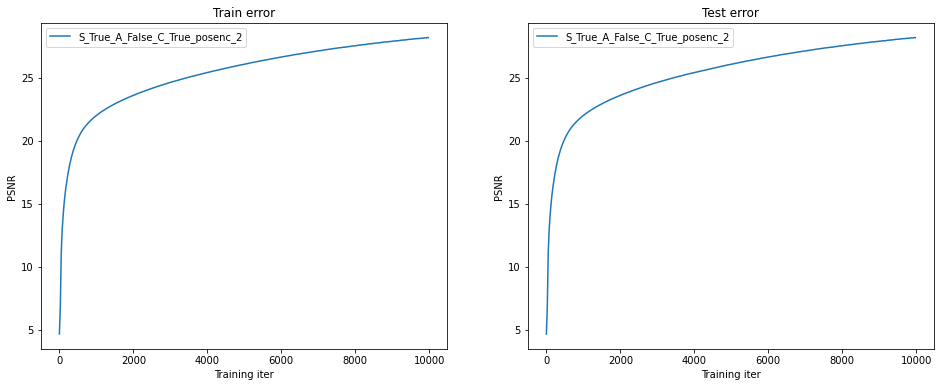

In [12]:
vis_res()

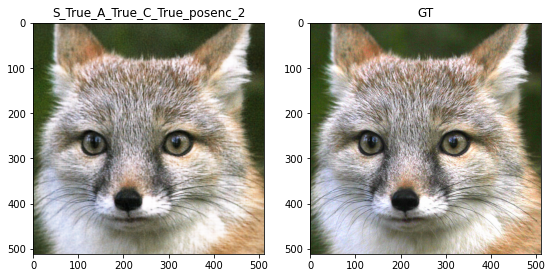

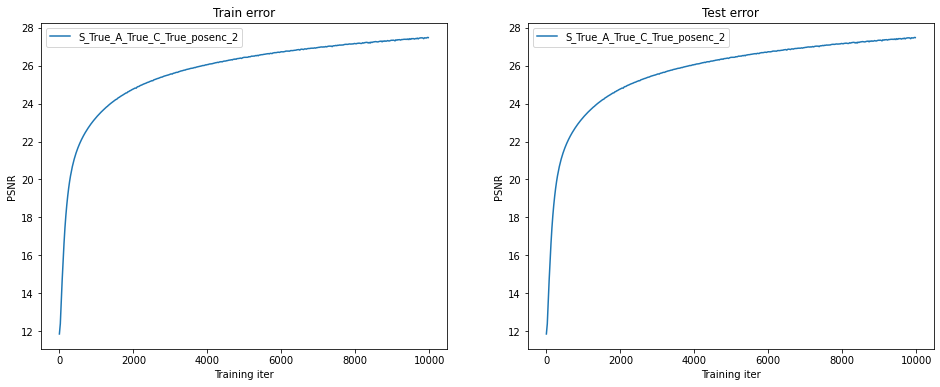

In [21]:
vis_res()

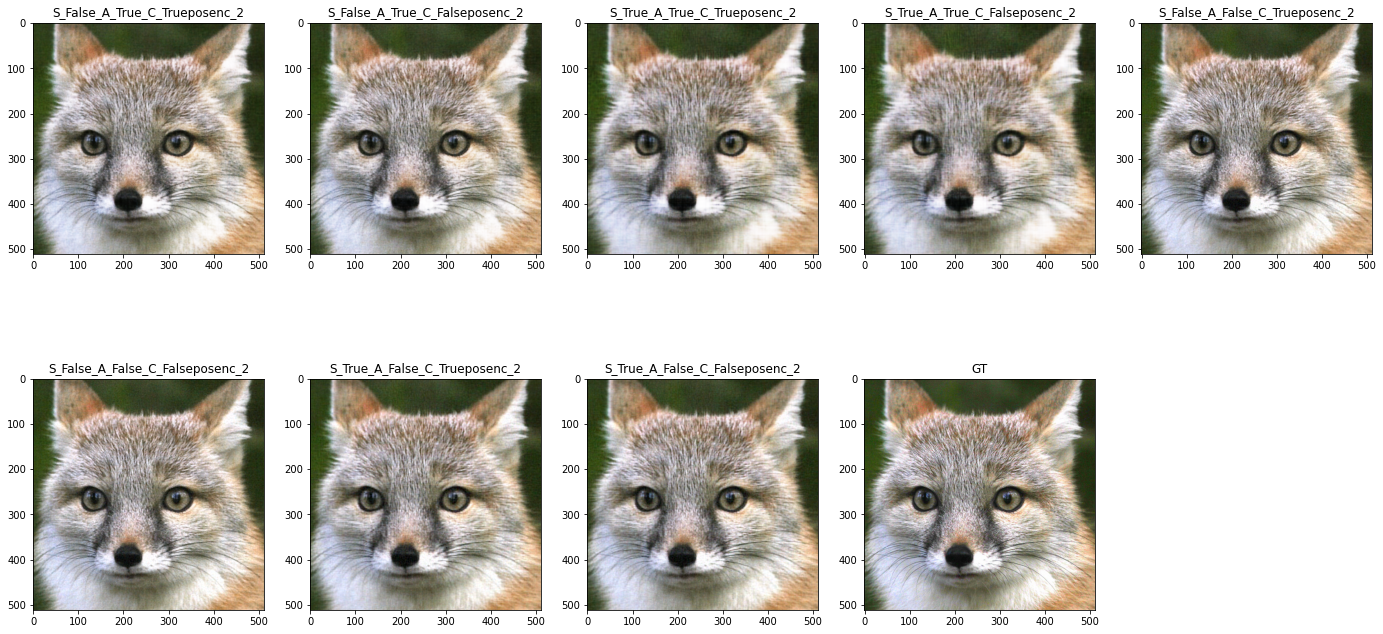

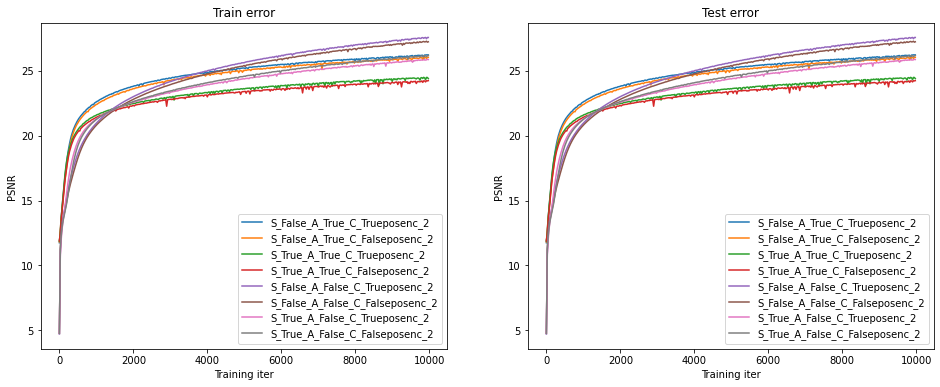

In [12]:
plt.figure(figsize=(24,12))
W = 5
N = len(outputs) + 1
H = (N - 1) // W + 1
for i, k in enumerate(outputs):
    plt.subplot(H,W,i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1].clip(0,1))
    plt.title(k)
plt.subplot(H,W,N)
plt.imshow(img)
plt.title('GT')
plt.show()

plt.figure(figsize=(16,6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [9]:
for k in outputs:
    print(outputs[k]['train_psnrs'][-1])

20.50487
18.404173
21.52812
25.229635
19.988928
18.165947
21.098759
23.47891
20.464705
17.742546
21.360373
25.274952
20.318958
18.25993
21.389933
24.886223


In [13]:
psnrs = {}
for k in outputs:
    print(k, outputs[k]['train_psnrs'][-1], outputs[k]['test_psnrs'][-1])
    psnrs[k] = {
        'train_psnrs': outputs[k]['train_psnrs'],
        'test_psnrs': outputs[k]['test_psnrs'],
    }
# np.save('2d_image/full_train_normal.npy', psnrs)

S_True_A_False_C_True_posenc_2 28.17541 28.17541


In [22]:
psnrs = {}
for k in outputs:
    print(k, outputs[k]['train_psnrs'][-1], outputs[k]['test_psnrs'][-1])
    psnrs[k] = {
        'train_psnrs': outputs[k]['train_psnrs'],
        'test_psnrs': outputs[k]['test_psnrs'],
    }
# np.save('2d_image/full_train_normal.npy', psnrs)
# S_True_A_False_C_True_posenc_2 28.17541 28.17541
# S_True_A_False_C_True_posenc_2 25.875591 25.875591
# S_True_A_True_C_True_posenc_2 27.477768 27.477768

S_True_A_True_C_True_posenc_2 27.477768 27.477768


In [7]:
psnrs = {}
for k in outputs:
    print(k, outputs[k]['train_psnrs'][-1], outputs[k]['test_psnrs'][-1])
    psnrs[k] = {
        'train_psnrs': outputs[k]['train_psnrs'],
        'test_psnrs': outputs[k]['test_psnrs'],
    }
# np.save('2d_image/full_train_normal.npy', psnrs)

S_False_A_True_C_Trueposenc_2 26.22742 26.22742
S_False_A_True_C_Falseposenc_2 26.040876 26.040876
S_True_A_True_C_Trueposenc_2 24.402458 24.402458
S_True_A_True_C_Falseposenc_2 24.244648 24.244648
S_False_A_False_C_Trueposenc_2 27.571768 27.571768
S_False_A_False_C_Falseposenc_2 27.239508 27.239508
S_True_A_False_C_Trueposenc_2 25.873587 25.873589
S_True_A_False_C_Falseposenc_2 26.178854 26.178854
